In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
import joblib
import os
import time

#import fasttext

import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
from safetensors.torch import save_file 

from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version (PyTorch build):", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

# Тест вычислений
x = torch.randn(1000, 1000).to('cuda')
y = torch.randn(1000, 1000).to('cuda')
z = torch.mm(x, y)
print("GPU computation succeeded:", z.mean().item())

CUDA available: True
CUDA version (PyTorch build): 12.6
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Ti
GPU computation succeeded: 0.014346580021083355


# Подготовка данных и EDA

In [3]:
# Загрузка данных
df = pd.read_csv("final_balanced_dataset.csv")
df.head(15)

,text,label
0,"IT-компания Prodamus, предоставляющая цифровые...",formal
1,ээ начать чтоб мы начинали эти,informal
2,Немецкие полицейские установили круглосуточное...,formal
3,как бы ночью не спим сидим делаем электронику,informal
4,Слон в в шутку пнул буйвола и попытался сбежат...,formal
5,в данной группе понял балбес блять,informal
6,Летевший в Чечню самолет российской авиакомпан...,formal
7,нахуя вообще этот войс опять сюда блять включи...,informal
8,и номер контактный оставьте пожалуйста,informal
9,Нутрициолог Кристина Журавлева развеяла главны...,formal


In [4]:
# Базовая информация
print("Размер датасета:", df.shape)
print(df.describe())

Размер датасета: (127332, 2)
                                                     text   label
count                                              127332  127332
unique                                             127332       2
top     IT-компания Prodamus, предоставляющая цифровые...  formal
freq                                                    1   63666



Пропущенные значения:
text     0
label    0
dtype: int64

Уникальные метки:
label
formal      63666
informal    63666
Name: count, dtype: int64

Дубликатов по тексту: 0


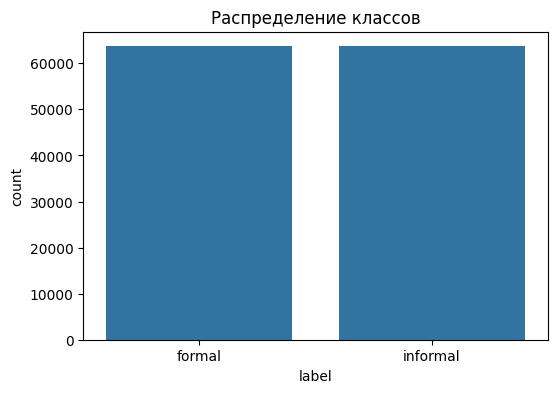

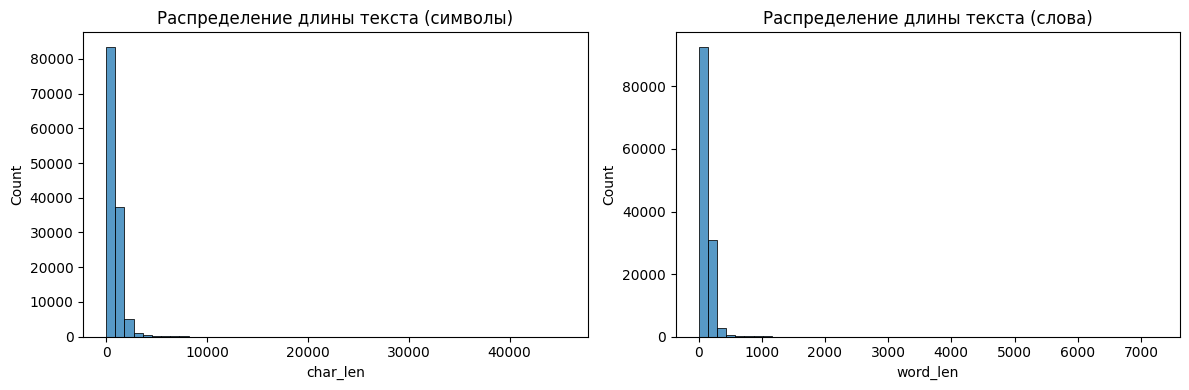

In [5]:
# Проверка на пропуски
print("\nПропущенные значения:")
print(df.isnull().sum())

# Удаление строк с пропусками
df = df.dropna().reset_index(drop=True)

# Проверка уникальных значений в label
print("\nУникальные метки:")
print(df['label'].value_counts())

# Проверка дубликатов
duplicates = df.duplicated(subset=['text']).sum()
print(f"\nДубликатов по тексту: {duplicates}")
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)

# Преобразуем метки в числа
label_map = {'informal': 0, 'formal': 1}
df['label_id'] = df['label'].map(label_map)

# Визуализация распределения классов
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Распределение классов")
plt.show()

# Длина текстов (по символам и словам)
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['char_len'], bins=50, kde=False)
plt.title("Распределение длины текста (символы)")

plt.subplot(1, 2, 2)
sns.histplot(df['word_len'], bins=50, kde=False)
plt.title("Распределение длины текста (слова)")
plt.tight_layout()
plt.show()


Текстов длиннее 512 токенов: 1573 из 127332 (1.24%)


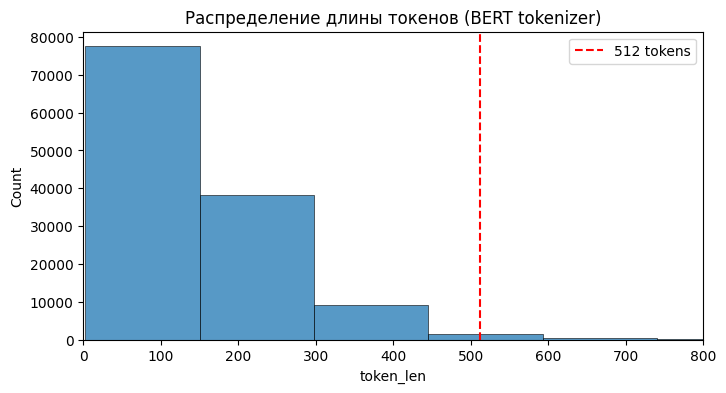

In [6]:
# Токенизация и проверка длины токенов (для BERT)
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def count_tokens(text):
    return len(tokenizer.encode(text, truncation=False))

df['token_len'] = df['text'].apply(count_tokens)

# Сколько текстов превышает 512 токенов?
over_512 = (df['token_len'] > 512).sum()
print(f"\nТекстов длиннее 512 токенов: {over_512} из {len(df)} ({over_512 / len(df) * 100:.2f}%)")

# Визуализация длины токенов
plt.figure(figsize=(8, 4))
sns.histplot(df['token_len'], bins=100, kde=False)
plt.axvline(512, color='red', linestyle='--', label='512 tokens')
plt.title("Распределение длины токенов (BERT tokenizer)")
plt.legend()
plt.xlim(0, 800)
plt.show()

In [7]:
# Разделение на train/val/test
from sklearn.model_selection import train_test_split

X = df['text'].tolist()
y = df['label_id'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 89132, Val: 19100, Test: 19100


# Обучение классификаторов

In [8]:
# Создаем папку для моделей
os.makedirs("models", exist_ok=True)

## Классические модели

### Векторизация (TF-IDF)

In [9]:
# Векторизация (TF-IDF)
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    lowercase=False
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
print(f"Размер TF-IDF матрицы: {X_train_tfidf.shape}")

Размер TF-IDF матрицы: (89132, 20000)


In [10]:
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

['models/tfidf_vectorizer.pkl']

In [11]:
def evaluate_and_save_sklearn(model, X_test_vec, y_true, name, save_path):
    y_pred = model.predict(X_test_vec)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # === Красивый вывод ===
    print(f"\n{'='*60}")
    print(f"Результаты модели: {name}")
    print(f"{'='*60}")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Macro F1:      {f1_macro:.4f}")
    print(f"Weighted F1:   {f1_weighted:.4f}")
    print(f"ROC-AUC:       {roc_auc:.4f}")
    print(f"PR-AUC:        {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("              Predicted")
    print("               informal   formal")
    print(f"Actual informal   {cm[0][0]:>6}   {cm[0][1]:>6}")
    print(f"       formal     {cm[1][0]:>6}   {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Сохранение
    joblib.dump(model, save_path)

    return {
        "name": name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }

### Логистическая регрессия

In [12]:
# Логистическая регрессия
#print("\nПодбор гиперпараметров для Logistic Regression...")
#lr_param_grid = {
#    'C': [0.1, 1.0, 10.0],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear', 'saga']
#}

#lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
#lr_grid = GridSearchCV(lr, lr_param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
#start_time = time.time()
#lr_grid.fit(X_train_tfidf, y_train)

#print(f"Подбор завершён за {time.time() - start_time:.2f} сек.")
#print(f"Лучшие параметры: {lr_grid.best_params_}")

#res_lr = evaluate_and_save_sklearn(lr_grid.best_estimator_, X_test_tfidf, y_test, "Logistic Regression (Optimized)", "models/lr_model.pkl")

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
res_lr = evaluate_and_save_sklearn(lr, X_test_tfidf, y_test, "Logistic Regression", "models/lr_model.pkl")



Результаты модели: Logistic Regression
Accuracy:      0.9864
Macro F1:      0.9864
Weighted F1:   0.9864
ROC-AUC:       0.9990
PR-AUC:        0.9991

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal     9495       55
       formal        204     9346

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.98      0.99      0.99      9550
      formal       0.99      0.98      0.99      9550

    accuracy                           0.99     19100
   macro avg       0.99      0.99      0.99     19100
weighted avg       0.99      0.99      0.99     19100



### SVM

In [13]:
# SVM
#print("\nПодбор гиперпараметров для SVM...")
#svm_param_grid = {
#    'C': [0.1, 1.0, 10.0],
#    'kernel': ['rbf', 'linear'],
#    'gamma': ['scale', 'auto']
#}

#svm = SVC(class_weight='balanced', probability=True, random_state=42)
#svm_rand = RandomizedSearchCV(svm, svm_param_grid, n_iter=5, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1, random_state=42)
#start_time = time.time()
#svm_rand.fit(X_train_tfidf, y_train)

#print(f"Подбор завершён за {time.time() - start_time:.2f} сек.")
#print(f"Лучшие параметры: {svm_rand.best_params_}")

#res_svm = evaluate_and_save_sklearn(svm_rand.best_estimator_, X_test_tfidf, y_test, "SVM (Optimized)", "models/svm_model.pkl")

svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_tfidf, y_train)
res_svm = evaluate_and_save_sklearn(svm, X_test_tfidf, y_test, "SVM", "models/svm_model.pkl")


Результаты модели: SVM
Accuracy:      0.9896
Macro F1:      0.9896
Weighted F1:   0.9896
ROC-AUC:       0.9994
PR-AUC:        0.9995

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal     9526       24
       formal        175     9375

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.98      1.00      0.99      9550
      formal       1.00      0.98      0.99      9550

    accuracy                           0.99     19100
   macro avg       0.99      0.99      0.99     19100
weighted avg       0.99      0.99      0.99     19100



### Naive Bayes

In [14]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
res_nb = evaluate_and_save_sklearn(nb, X_test_tfidf, y_test, "Naive Bayes", "models/nb_model.pkl")


Результаты модели: Naive Bayes
Accuracy:      0.9736
Macro F1:      0.9736
Weighted F1:   0.9736
ROC-AUC:       0.9972
PR-AUC:        0.9978

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal     9169      381
       formal        124     9426

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.99      0.96      0.97      9550
      formal       0.96      0.99      0.97      9550

    accuracy                           0.97     19100
   macro avg       0.97      0.97      0.97     19100
weighted avg       0.97      0.97      0.97     19100



### Ансамбль

In [ ]:
# Ансамбль
ensemble = VotingClassifier(
    #estimators=[('lr', lr_grid.best_estimator_), ('svm', svm_rand.best_estimator_), ('nb', nb)],
    estimators=[('lr', lr), ('svm', svm), ('nb', nb)],
    voting='soft'
)
ensemble.fit(X_train_tfidf, y_train)
res_ens = evaluate_and_save_sklearn(ensemble, X_test_tfidf, y_test, "Ensemble", "models/ensemble_model.pkl")


Результаты модели: Ensemble
Accuracy:      0.9904
Macro F1:      0.9904
Weighted F1:   0.9904
ROC-AUC:       0.9990
PR-AUC:        0.9991

--- Confusion Matrix ---
              Predicted
               informal   formal
Actual informal     9476       74
       formal        110     9440

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.99      0.99      0.99      9550
      formal       0.99      0.99      0.99      9550

    accuracy                           0.99     19100
   macro avg       0.99      0.99      0.99     19100
weighted avg       0.99      0.99      0.99     19100



['models/tfidf_vectorizer.pkl']

In [ ]:
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

### FastText

In [28]:
# FastText
#fasttext_results = None

# Подготовка формата FastText
#with open("train_fasttext.txt", "w", encoding="utf-8") as f:
#        for text, label in zip(X_train, y_train):
#            ft_label = "__label__formal" if label == 1 else "__label__informal"
#            f.write(f"{ft_label} {text}\n")
#with open("test_fasttext.txt", "w", encoding="utf-8") as f:
#    for text, label in zip(X_test, y_test):
#        ft_label = "__label__formal" if label == 1 else "__label__informal"
#        f.write(f"{ft_label} {text}\n")

# Обучение
#ft_model = fasttext.train_supervised("train_fasttext.txt", epoch=25, lr=1.0, wordNgrams=2, dim=100, loss='ova')
#ft_model.save_model("models/fasttext_model.bin")

# Оценка
#y_pred_ft, y_proba_ft = [], []
#for text in X_test:
#    labels, probs = ft_model.predict(text, k=2)
#    prob_formal = dict(zip(labels, probs)).get("__label__formal", 0.0)
#    pred = 1 if prob_formal > 0.5 else 0
#    y_pred_ft.append(pred)
#    y_proba_ft.append(prob_formal)

#y_pred_ft = np.array(y_pred_ft)
#y_proba_ft = np.array(y_proba_ft)

#acc = accuracy_score(y_test, y_pred_ft)
#f1_macro = f1_score(y_test, y_pred_ft, average='macro')
#f1_weighted = f1_score(y_test, y_pred_ft, average='weighted')
#roc_auc = roc_auc_score(y_test, y_proba_ft)
#pr_auc = average_precision_score(y_test, y_proba_ft)
#cm = confusion_matrix(y_test, y_pred_ft)

#print(f"\nFastText (Test):")
#print(f"  Accuracy: {acc:.4f}")
#print(f"  Macro F1: {f1_macro:.4f}")
#print(f"  Weighted F1: {f1_weighted:.4f}")
#print(f"  ROC-AUC: {roc_auc:.4f}")
#print(f"  PR-AUC: {pr_auc:.4f}")
#print(f"  Confusion Matrix:\n{cm}")

#fasttext_results = {
#    'name': 'FastText', 'acc': acc, 'f1_macro': f1_macro,
#    'f1_weighted': f1_weighted, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'cm': cm
#}


## Нейросети  Bi-LSTM и CNN

In [16]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nУстройство: {device}")


Устройство: cuda


In [17]:
# Подготовка данных
def build_vocab(texts, min_freq=2):
    from collections import Counter
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [18]:
vocab = build_vocab(X_train)
MAX_LEN = 256

In [19]:
def text_to_seq(text, vocab, max_len=MAX_LEN):
    seq = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return seq[:max_len]

In [20]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        seq = text_to_seq(self.texts[idx], self.vocab, self.max_len)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [21]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.stack(labels)

In [22]:
train_dataset = TextDataset(X_train, y_train, vocab)
val_dataset = TextDataset(X_val, y_val, vocab)
test_dataset = TextDataset(X_test, y_test, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)

In [23]:
# Валидация
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    return val_loss, acc, f1_macro, all_labels, all_preds

In [24]:
# Обучение с логами и графиками
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs, model_name, patience=3):
    model.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1s = []

    best_f1 = 0
    trigger_times = 0

    print(f"\nОбучение {model_name}...")
    for epoch in range(epochs):
        # Обучение
        model.train()
        total_train_loss = 0
        for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        val_loss, val_acc, val_f1, val_true, val_pred = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val Macro F1: {val_f1:.4f}")

        # Early Stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger_times = 0
            torch.save(model.state_dict(), f"models/{model_name.lower().replace(' ', '_')}_best.pth")
            print("Сохранена лучшая модель!")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping на эпохе {epoch+1}")
                break

    # --- Графики ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.title(f'{model_name}: Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, color='green', marker='s')
    plt.title(f'{model_name}: Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(val_f1s, color='purple', marker='^')
    plt.title(f'{model_name}: Val Macro F1')
    plt.xlabel('Epoch'); plt.ylabel('Macro F1'); plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"models/{model_name.lower().replace(' ', '_')}_training.png", dpi=150)
    plt.show()

    return train_losses, val_losses, val_accuracies, val_f1s

### Bi-LSTM

In [25]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = torch.cat([h_n[-2], h_n[-1]], dim=1)
        return self.fc(self.dropout(out))


Обучение Bi-LSTM...


Epoch 1/6 | Train Loss: 0.1004 | Val Loss: 0.0285 | Val Acc: 0.9911 | Val Macro F1: 0.9911
Сохранена лучшая модель!


Epoch 2/6 | Train Loss: 0.0270 | Val Loss: 0.0196 | Val Acc: 0.9937 | Val Macro F1: 0.9937
Сохранена лучшая модель!


Epoch 3/6 | Train Loss: 0.0694 | Val Loss: 0.0185 | Val Acc: 0.9940 | Val Macro F1: 0.9940
Сохранена лучшая модель!


Epoch 4/6 | Train Loss: 0.0160 | Val Loss: 0.0178 | Val Acc: 0.9940 | Val Macro F1: 0.9940


Epoch 5/6 | Train Loss: 0.0125 | Val Loss: 0.0228 | Val Acc: 0.9924 | Val Macro F1: 0.9924


Epoch 6/6 | Train Loss: 0.0216 | Val Loss: 0.0148 | Val Acc: 0.9951 | Val Macro F1: 0.9951
Сохранена лучшая модель!


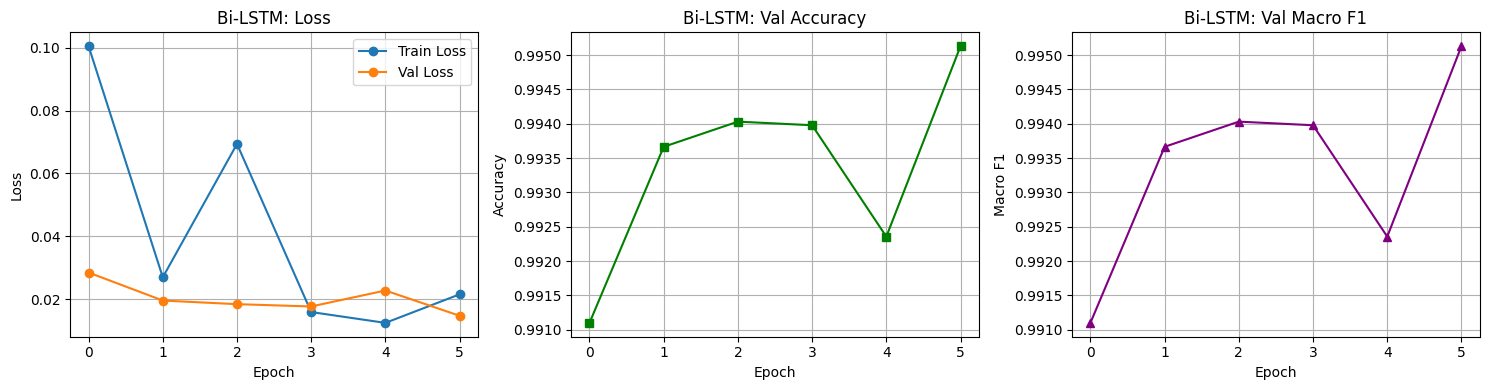

([0.10043441385559922,
  0.02702482622924942,
  0.06936730350839404,
  0.015987556749384527,
  0.012544387694343268,
  0.021616474121845527],
 [0.028542506654924374,
  0.019643016290161013,
  0.018491951719527583,
  0.017758142452275874,
  0.0228273498227689,
  0.014801176114544743],
 [0.9910994764397906,
  0.9936649214659686,
  0.9940314136125654,
  0.9939790575916231,
  0.9923560209424084,
  0.995130890052356],
 [0.9910994716578395,
  0.99366482378398,
  0.9940313924088828,
  0.9939789790135114,
  0.9923559685587604,
  0.9951308755174568])

In [26]:
bilstm = BiLSTMClassifier(len(vocab)).to(device)
optimizer_bilstm = torch.optim.Adam(bilstm.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train(
    model=bilstm,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_bilstm,
    criterion=criterion,
    device=device,
    epochs=6,
    model_name="Bi-LSTM",
    patience=3
)

### CNN

In [27]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=2, num_filters=50, filter_sizes=[3,4,5]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, fs) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        conv_outs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(-1)).squeeze(-1) for c in conv_outs]
        x = torch.cat(pooled, dim=1)
        return self.fc(self.dropout(x))


Обучение CNN...


Epoch 1/6 | Train Loss: 0.0894 | Val Loss: 0.0307 | Val Acc: 0.9905 | Val Macro F1: 0.9905
Сохранена лучшая модель!


Epoch 2/6 | Train Loss: 0.0345 | Val Loss: 0.0234 | Val Acc: 0.9923 | Val Macro F1: 0.9923
Сохранена лучшая модель!


Epoch 3/6 | Train Loss: 0.0247 | Val Loss: 0.0213 | Val Acc: 0.9935 | Val Macro F1: 0.9935
Сохранена лучшая модель!


Epoch 4/6 | Train Loss: 0.0201 | Val Loss: 0.0181 | Val Acc: 0.9938 | Val Macro F1: 0.9938
Сохранена лучшая модель!


Epoch 5/6 | Train Loss: 0.0164 | Val Loss: 0.0168 | Val Acc: 0.9942 | Val Macro F1: 0.9942
Сохранена лучшая модель!


Epoch 6/6 | Train Loss: 0.0141 | Val Loss: 0.0171 | Val Acc: 0.9937 | Val Macro F1: 0.9937


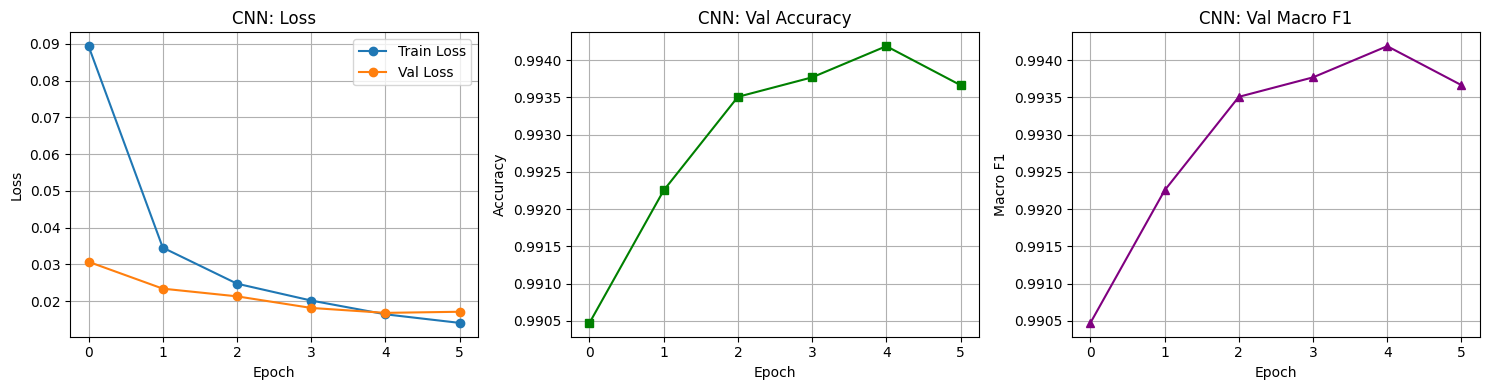

([0.08935839121550193,
  0.034537317912072235,
  0.024735180382370783,
  0.02014379553718804,
  0.016400168648724057,
  0.014066962058563488],
 [0.03068384009625227,
  0.023381571718382597,
  0.021288095603939957,
  0.018134931047886212,
  0.01679292181720895,
  0.017094965140727725],
 [0.9904712041884817,
  0.9922513089005236,
  0.9935078534031414,
  0.9937696335078534,
  0.9941884816753926,
  0.9936649214659686],
 [0.9904711335597849,
  0.9922512843466043,
  0.9935078531184058,
  0.9937696101274534,
  0.994188462160758,
  0.9936648075294049])

In [28]:
cnn = CNNClassifier(len(vocab)).to(device)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train(
    model=cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_cnn,
    criterion=criterion,
    device=device,
    epochs=6,
    model_name="CNN",
    patience=3
)

In [29]:
# Оценка на тесте
def evaluate_torch_model_with_metrics(model, loader, device, model_name):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_proba = np.array(all_probs)

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Вывод
    print(f"\n=== Результаты модели: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("          Predicted")
    print("           Informal Formal")
    print(f"Actual Informal   {cm[0][0]:>6} {cm[0][1]:>6}")
    print(f"       Formal     {cm[1][0]:>6} {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    return {
        "name": model_name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }


In [30]:
# Оценка
res_bilstm = evaluate_torch_model_with_metrics(bilstm, test_loader, device, "Bi-LSTM")


=== Результаты модели: Bi-LSTM ===
Accuracy: 0.9932
Macro F1: 0.9932
Weighted F1: 0.9932
ROC-AUC: 0.9996
PR-AUC: 0.9996

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal     9494     56
       Formal         73   9477

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.99      0.99      0.99      9550
      formal       0.99      0.99      0.99      9550

    accuracy                           0.99     19100
   macro avg       0.99      0.99      0.99     19100
weighted avg       0.99      0.99      0.99     19100



In [31]:
res_cnn = evaluate_torch_model_with_metrics(cnn, test_loader, device, "CNN")


=== Результаты модели: CNN ===
Accuracy: 0.9926
Macro F1: 0.9926
Weighted F1: 0.9926
ROC-AUC: 0.9997
PR-AUC: 0.9997

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal     9507     43
       Formal         98   9452

--- Classification Report ---
              precision    recall  f1-score   support

    informal       0.99      1.00      0.99      9550
      formal       1.00      0.99      0.99      9550

    accuracy                           0.99     19100
   macro avg       0.99      0.99      0.99     19100
weighted avg       0.99      0.99      0.99     19100



#  Fine-tuning BERT

In [32]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [33]:
def encode_texts(texts, tokenizer, max_length=512):
    return tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

print("Кодирование текстов для BERT...")

# Train
train_enc = encode_texts(X_train, tokenizer)
train_dataset_bert = TensorDataset(
    train_enc['input_ids'], train_enc['attention_mask'],
    torch.tensor(y_train, dtype=torch.long)
)

# Val
val_enc = encode_texts(X_val, tokenizer)
val_dataset_bert = TensorDataset(
    val_enc['input_ids'], val_enc['attention_mask'],
    torch.tensor(y_val, dtype=torch.long)
)

# Test
test_enc = encode_texts(X_test, tokenizer)
test_dataset_bert = TensorDataset(
    test_enc['input_ids'], test_enc['attention_mask'],
    torch.tensor(y_test, dtype=torch.long)
)

Кодирование текстов для BERT...


In [34]:
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True, pin_memory=True, num_workers=0)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

In [35]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=2):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(self.dropout(outputs.pooler_output))

In [36]:
bert_backbone = AutoModel.from_pretrained(model_name)
model_bert = BERTClassifier(bert_backbone).to(device)
optimizer = AdamW(model_bert.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Списки для графиков
train_losses = []
val_losses = []
val_f1s = []

# Вспомогательная функция валидации
def validate_bert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, all_labels, all_preds


Fine-tuning RuBERT...


Epoch 1/1: 100%|██████████| 5571/5571 [28:27<00:00,  3.26it/s]


Epoch 1/1 | Train Loss: 0.0100 | Val Loss: 0.0041 | Val Macro F1: 0.9988
Сохранена лучшая модель!


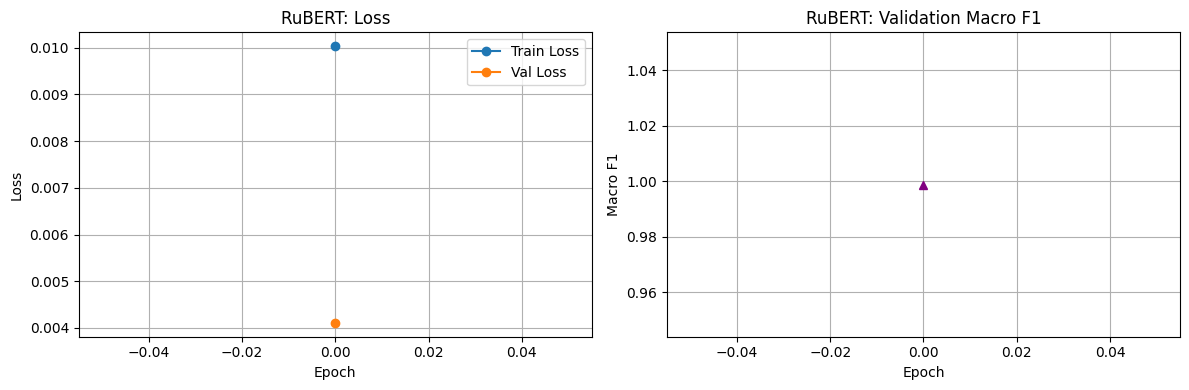

In [38]:
# Обучение с графиками
best_f1 = 0
patience = 2
trigger_times = 0
num_epochs = 1

print("\nFine-tuning RuBERT...")
for epoch in range(num_epochs):
    # Обучение
    model_bert.train()
    total_train_loss = 0
    for batch in tqdm(train_loader_bert, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids, attention_mask, labels = [b.to(device, non_blocking=True) for b in batch]
        optimizer.zero_grad()
        outputs = model_bert(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader_bert)
    train_losses.append(avg_train_loss)

    # Валидация
    val_loss, val_f1, _, _ = validate_bert(model_bert, val_loader_bert, criterion, device)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        trigger_times = 0
        torch.save(model_bert.state_dict(), "models/bert_classifier_best.pth")
        print("Сохранена лучшая модель!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

# Графики обучения для BERT
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('RuBERT: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val Macro F1', color='purple', marker='^')
plt.title('RuBERT: Validation Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.grid(True)

plt.tight_layout()
plt.savefig("models/bert_training.png", dpi=150)
plt.show()

In [40]:
def evaluate_bert_with_metrics(model, loader, device, model_name):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Передаем в модель оба тензора
            outputs = model(input_ids, attention_mask)

            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_proba = np.array(all_probs)

    # Метрики
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Вывод
    print(f"\n=== Результаты модели: {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    print("\n--- Confusion Matrix ---")
    print("          Predicted")
    print("           Informal Formal")
    print(f"Actual Informal   {cm[0][0]:>6} {cm[0][1]:>6}")
    print(f"       Formal     {cm[1][0]:>6} {cm[1][1]:>6}")

    print("\n--- Classification Report ---")
    target_names = ['informal', 'formal']
    print(classification_report(y_true, y_pred, target_names=target_names))

    return {
        "name": model_name,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "cm": cm
    }

In [41]:
# Оценка
res_bert = evaluate_bert_with_metrics(model_bert, test_loader_bert, device, "RuBERT")


=== Результаты модели: RuBERT ===
Accuracy: 0.9984
Macro F1: 0.9984
Weighted F1: 0.9984
ROC-AUC: 1.0000
PR-AUC: 1.0000

--- Confusion Matrix ---
          Predicted
           Informal Formal
Actual Informal     9527     23
       Formal          7   9543

--- Classification Report ---
              precision    recall  f1-score   support

    informal       1.00      1.00      1.00      9550
      formal       1.00      1.00      1.00      9550

    accuracy                           1.00     19100
   macro avg       1.00      1.00      1.00     19100
weighted avg       1.00      1.00      1.00     19100



# Сводка и анализ

In [42]:
# Собираем все результаты
all_results = [
    res_lr,
    res_svm,
    res_nb,
    res_ens,
    res_bilstm,
    res_cnn,
    res_bert
]

In [46]:
# Сводная таблица
summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'cm'} for r in all_results])
print("\nСводная таблица моделей (сортировка по Macro F1):")
summary_df.sort_values('f1_macro', ascending=False).to_string(index=False)
summary_df


Сводная таблица моделей (сортировка по Macro F1):


,name,acc,f1_macro,f1_weighted,roc_auc,pr_auc
0,Logistic Regression,0.986440,0.986439,0.986439,0.999002,0.999098
1,SVM,0.989581,0.989581,0.989581,0.999420,0.999483
2,Naive Bayes,0.973560,0.973555,0.973555,0.997190,0.997775
3,Ensemble,0.990366,0.990366,0.990366,0.998998,0.999133
4,Bi-LSTM,0.993246,0.993246,0.993246,0.999623,0.999600
5,CNN,0.992618,0.992618,0.992618,0.999659,0.999673
6,RuBERT,0.998429,0.998429,0.998429,0.999978,0.999978


In [44]:
# Лучшая модель
best_model = max(all_results, key=lambda x: x['f1_macro'])
print(f"\nЛучшая модель: {best_model['name']} (Macro F1 = {best_model['f1_macro']:.4f})")


Лучшая модель: RuBERT (Macro F1 = 0.9984)


In [45]:
# Примеры ошибок (на примере RuBERT)
if best_model['name'] == 'RuBERT':
    model_bert.eval()
    errors = []
    for i, batch in enumerate(test_loader_bert):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model_bert(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
        for j in range(len(labels)):
            if preds[j] != labels[j]:
                idx = i * 16 + j
                if idx < len(X_test):
                    text = X_test[idx]
                    true_label = "formal" if labels[j].item() == 1 else "informal"
                    pred_label = "formal" if preds[j].item() == 1 else "informal"
                    errors.append((text, true_label, pred_label))
                    if len(errors) >= 3:
                        break
        if len(errors) >= 3:
            break

    print("\nПримеры ошибок RuBERT:")
    for text, true, pred in errors:
        print(f"Текст: {text[:120]}...")
        print(f"Истинный: {true} → Предсказанный: {pred}\n")


Примеры ошибок RuBERT:
Текст: Но разговор сам собой с того, как бы устроить детям счастливое и беспечное детство, сворачивает на необходимость объясни...
Истинный: formal → Предсказанный: informal

Текст: Они все плохие, очень плохие дети. Стыд вам и срам. Стыд и срам, стыд и срам, стыд и срам. - Стыд и срам, - Молодчага, п...
Истинный: informal → Предсказанный: formal

Текст: Поздравляем Людмилу Педан с прохождением в состав ГРАЖДАНСКОГО СОВЕТА при фракции КПРФ в Государственной Думе. Вот резул...
Истинный: informal → Предсказанный: formal



# Анализ причин ошибок
Возможные причины ошибок:
* Смешанный стиль (официальный текст с разговорными вставками)
* Очень короткие тексты (<5 слов) — мало контекста
* Использование формальных конструкций в неформальном контексте (ирония, цитаты)* Тексты длиной >512 токенов (BERT обрезает их)
* Недостаток разнообразия в обучающей выборке для редких случаев
* Высокая вариативность разговорной речи (сленг, эмодзи, опечатки)